# Modeling
Shpaner, Leonid  
Robinson, Christopher  
Luis-Estrada, Jose  

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library

/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library


In [3]:
####################################
## import the requisite libraries ##
####################################
import os
import csv
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import stats models for q-q plots and 
# baseline logistic regression
import statsmodels.api as sm

import warnings
# suppress warnings for cleaner output
warnings.filterwarnings('ignore')
# suppress future warnings for cleaner output
warnings.filterwarnings(action='ignore', category=FutureWarning)

# import modeling libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, mean_squared_error,\
precision_score, recall_score, f1_score, accuracy_score,\
confusion_matrix, plot_confusion_matrix, classification_report

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# set random state for reproducibility
rstate = 42

In [5]:
# check current working directory
current_directory = os.getcwd()
current_directory

'/content/drive/Shared drives/Capstone - Best Group/navigating_crime/Code Library'

### Assign Paths to Folders

In [6]:
# path to data folder
data_path1 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/'

# path to the training file
data_path2 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/train_set.csv'

# path to the validation file
data_path3 = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
             'Data Folder/valid_set.csv'             

# path to the image library
image_path = '/content/drive/Shareddrives/Capstone - Best Group/navigating_crime'\
          + '/Image Folder'        

In [7]:
# bring in original dataframe only for join purposes
train_set = pd.read_csv(data_path2).set_index('OBJECTID')
valid_set = pd.read_csv(data_path3).set_index('OBJECTID')

In [8]:
train_set.shape

(21036, 36)

In [9]:
valid_set.shape

(10518, 36)

In [10]:
train_set.head()

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Driveway,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Crime_Code,Gender
OBJECTID,,,,,,,,,,,,,,,,,,,,,
146996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,34,1,0,2
12913,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,34,2,1,1
199420,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,2
139528,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,14,2,0,1
91647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,36,5,1,2


In [11]:
valid_set.head()

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Driveway,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Crime_Code,Gender
OBJECTID,,,,,,,,,,,,,,,,,,,,,
62203,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,46,6,0,2
233319,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,32,6,1,2
95157,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,26,6,1,1
83900,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,28,1,1,1
61476,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,57,5,1,1


In [12]:
dev_set = pd.concat([train_set, valid_set], axis=0)

In [13]:
X_train = train_set.drop(columns=['Crime_Code'])
y_train = pd.DataFrame(train_set['Crime_Code'])

X_val = valid_set.drop(columns=['Crime_Code'])
y_val = pd.DataFrame(valid_set['Crime_Code'])

## Logistic Regression

Cost = 0.01 	 Validation Accuracy = 0.62
Cost = 0.10 	 Validation Accuracy = 0.62
Cost = 8.00 	 Validation Accuracy = 0.62
Cost = 10.00 	 Validation Accuracy = 0.62
Cost = 20.00 	 Validation Accuracy = 0.62
Cost = 50.00 	 Validation Accuracy = 0.62


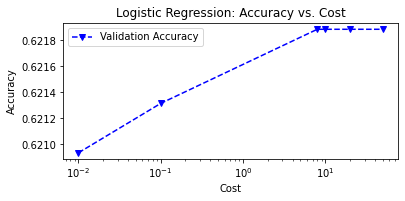

In [14]:
# Manually Tuning The Logistic Regression Model
C = [0.01, 0.1, 8, 10, 20, 50]
LRvalAcc = []
for param in C:
    lr = LogisticRegression(solver='saga', penalty = 'elasticnet', l1_ratio =0.2,
                            C = param, 
                            max_iter=1000, random_state=rstate)
    lr.fit(X_train, y_train)

    # Predict on val set
    tuned_lr = lr.predict(X_val)
    LRvalAcc.append(accuracy_score(y_val, tuned_lr))
    print('Cost = %2.2f \t Validation Accuracy = %2.2f' \
          %(param,accuracy_score(y_val, tuned_lr)))

# plot cost by accuracy
fig, ax = plt.subplots(figsize=(6,2.5))
ax.plot(C, LRvalAcc,'bv--')
ax.legend(['Validation Accuracy'])
plt.title('Logistic Regression: Accuracy vs. Cost')
ax.set_xlabel('Cost'); ax.set_xscale('log')
ax.set_ylabel('Accuracy')
plt.show()

In [15]:
# accuracy and classification report (Tuned Model)
print('Tuned Logistic Regression Model')
print('Accuracy Score')
print(accuracy_score(y_val, tuned_lr))
print('Classification Report \n', 
       classification_report(y_val, tuned_lr))

Tuned Logistic Regression Model
Accuracy Score
0.6218862901692337
Classification Report 
               precision    recall  f1-score   support

           0       0.62      0.47      0.54      4861
           1       0.62      0.75      0.68      5657

    accuracy                           0.62     10518
   macro avg       0.62      0.61      0.61     10518
weighted avg       0.62      0.62      0.61     10518



Max Depth =  1 	 val Accuracy = 0.55 	     Training Accuracy = 0.55
Max Depth =  2 	 val Accuracy = 0.59 	     Training Accuracy = 0.59
Max Depth =  3 	 val Accuracy = 0.61 	     Training Accuracy = 0.60
Max Depth =  4 	 val Accuracy = 0.63 	     Training Accuracy = 0.62
Max Depth =  5 	 val Accuracy = 0.64 	     Training Accuracy = 0.64
Max Depth =  6 	 val Accuracy = 0.64 	     Training Accuracy = 0.64
Max Depth =  7 	 val Accuracy = 0.65 	     Training Accuracy = 0.65
Max Depth =  8 	 val Accuracy = 0.66 	     Training Accuracy = 0.67
Max Depth =  9 	 val Accuracy = 0.67 	     Training Accuracy = 0.68
Max Depth = 10 	 val Accuracy = 0.68 	     Training Accuracy = 0.70
Max Depth = 11 	 val Accuracy = 0.70 	     Training Accuracy = 0.72
Max Depth = 12 	 val Accuracy = 0.72 	     Training Accuracy = 0.75
Max Depth = 13 	 val Accuracy = 0.73 	     Training Accuracy = 0.78
Max Depth = 14 	 val Accuracy = 0.75 	     Training Accuracy = 0.80


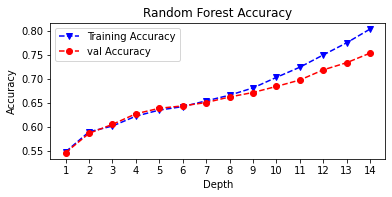

In [16]:
# Random Forest Tuning (Manual)
rf_train_accuracy = []
rf_val_accuracy = []
for n in range(1, 15):
    rf = RandomForestClassifier(max_depth = n, 
                                random_state=rstate)
    rf = rf.fit(X_train, y_train)
    rf_pred_train = rf.predict(X_train)
    rf_pred_val = rf.predict(X_val)
    rf_train_accuracy.append(accuracy_score(y_train, 
                                            rf_pred_train))
    rf_val_accuracy.append(accuracy_score(y_val, 
                                            rf_pred_val))
    print('Max Depth = %2.0f \t val Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (n, accuracy_score(y_val,
                                                  rf_pred_val),
                               accuracy_score(y_train,
                                              rf_pred_train)))
max_depth = list(range(1, 15))
fig, plt.subplots(figsize=(6,2.5))
plt.plot(max_depth, rf_train_accuracy, 'bv--', 
         label='Training Accuracy')
plt.plot(max_depth, rf_val_accuracy, 'ro--', 
         label='val Accuracy')
plt.title('Random Forest Accuracy')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.xticks(max_depth)
plt.legend()
plt.show()

In [17]:
# accuracy and classification report
print('Tuned Random Forest Model')
print('Accuracy Score')
print(accuracy_score(y_val, rf_pred_val))
print('Classification Report \n', 
       classification_report(y_val, rf_pred_val))

Tuned Random Forest Model
Accuracy Score
0.7537554668187868
Classification Report 
               precision    recall  f1-score   support

           0       0.78      0.65      0.71      4861
           1       0.74      0.84      0.79      5657

    accuracy                           0.75     10518
   macro avg       0.76      0.75      0.75     10518
weighted avg       0.76      0.75      0.75     10518



In [18]:
et_train_accuracy = []
et_val_accuracy = []
for n in range(1, 25):
    et = ExtraTreesClassifier(max_depth = n, 
                              n_estimators = 1000,
                              min_samples_split = 15,
                              criterion='entropy',
                              random_state=rstate)
    et = et.fit(X_train, y_train)
    et_pred_train = et.predict(X_train)
    et_pred_val = et.predict(X_val)
    et_train_accuracy.append(accuracy_score(y_train, 
                                            et_pred_train))
    et_val_accuracy.append(accuracy_score(y_val, 
                                            et_pred_val))
    print('Max Depth = %2.0f \t val Accuracy = %2.2f \t \
    Training Accuracy = %2.2f'% (n, accuracy_score(y_val,
                                                  et_pred_val),
                              accuracy_score(y_train,
                                              et_pred_train)))

Max Depth =  1 	 val Accuracy = 0.54 	     Training Accuracy = 0.55
Max Depth =  2 	 val Accuracy = 0.55 	     Training Accuracy = 0.55
Max Depth =  3 	 val Accuracy = 0.58 	     Training Accuracy = 0.59
Max Depth =  4 	 val Accuracy = 0.60 	     Training Accuracy = 0.61
Max Depth =  5 	 val Accuracy = 0.61 	     Training Accuracy = 0.62
Max Depth =  6 	 val Accuracy = 0.63 	     Training Accuracy = 0.63
Max Depth =  7 	 val Accuracy = 0.63 	     Training Accuracy = 0.64
Max Depth =  8 	 val Accuracy = 0.65 	     Training Accuracy = 0.66
Max Depth =  9 	 val Accuracy = 0.66 	     Training Accuracy = 0.67
Max Depth = 10 	 val Accuracy = 0.66 	     Training Accuracy = 0.68
Max Depth = 11 	 val Accuracy = 0.67 	     Training Accuracy = 0.69
Max Depth = 12 	 val Accuracy = 0.68 	     Training Accuracy = 0.70
Max Depth = 13 	 val Accuracy = 0.69 	     Training Accuracy = 0.71
Max Depth = 14 	 val Accuracy = 0.70 	     Training Accuracy = 0.73
Max Depth = 15 	 val Accuracy = 0.71 	     Train

In [19]:
# accuracy and classification report
print('Tuned Extra Trees Model')
print('Accuracy Score')
print(accuracy_score(y_val, et_pred_val))
print('Classification Report \n', 
       classification_report(y_val, et_pred_val))

Tuned Extra Trees Model
Accuracy Score
0.7531850161627686
Classification Report 
               precision    recall  f1-score   support

           0       0.76      0.67      0.72      4861
           1       0.75      0.82      0.78      5657

    accuracy                           0.75     10518
   macro avg       0.75      0.75      0.75     10518
weighted avg       0.75      0.75      0.75     10518



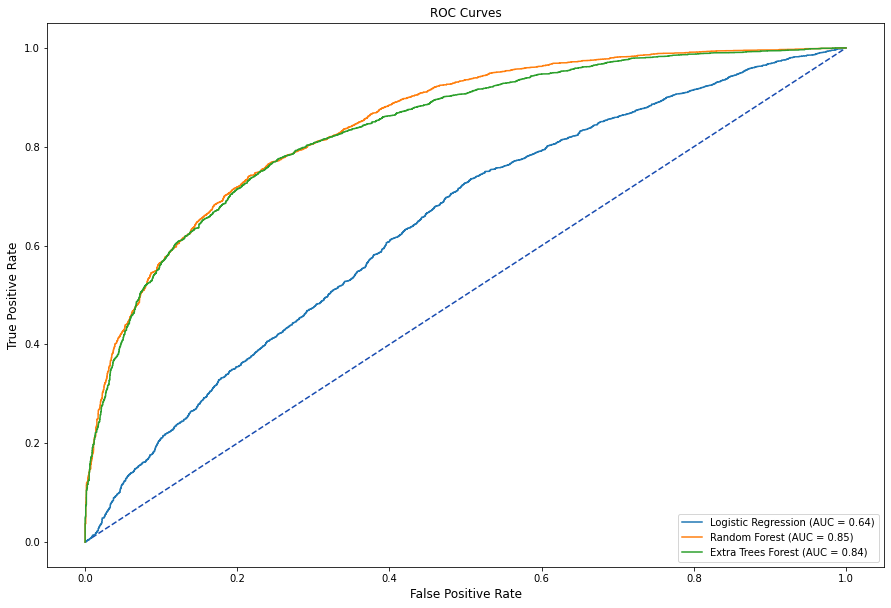

In [20]:
lr_pred = lr.predict_proba(X_val)[:, 1]
rf_pred = rf.predict_proba(X_val)[:, 1]
et_pred = et.predict_proba(X_val)[:, 1]

tuned_lr_roc = metrics.roc_curve(y_val, lr_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_val, lr_pred)
tuned_lr_auc = metrics.auc(fpr, tpr)
tuned_lr_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc = tuned_lr_auc, 
estimator_name = 'Logistic Regression')

tuned_rf_roc = metrics.roc_curve(y_val, rf_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_val, rf_pred)
tuned_rf_auc = metrics.auc(fpr, tpr)
tuned_rf_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc = tuned_rf_auc, 
estimator_name = 'Random Forest')


tuned_et_roc = metrics.roc_curve(y_val, et_pred)
fpr,tpr,thresholds = metrics.roc_curve(y_val, et_pred)
tuned_ef_auc = metrics.auc(fpr, tpr)
tuned_ef_plot = metrics.RocCurveDisplay(fpr=fpr,tpr=tpr, 
roc_auc = tuned_ef_auc, 
estimator_name = 'Extra Trees Forest')

# Model ROC Plots Defined above
# plot set up
fig, ax = plt.subplots(figsize=(15, 10))
plt.title('ROC Curves', fontsize=12)
plt.plot([0, 1], [0, 1], linestyle = '--', 
         color = '#174ab0')
plt.xlabel('',fontsize=12) 
plt.ylabel('',fontsize=12) 
tuned_lr_plot.plot(ax)
tuned_rf_plot.plot(ax)
tuned_ef_plot.plot(ax)
plt.show()

In [21]:
df_predictions = valid_set.copy()

In [22]:
y_preds = lr.predict_proba(X_val)[:, 1]

In [23]:
df_preds = pd.concat([X_val, y_val], axis=1)
df_preds['Predictions'] = y_preds

In [24]:
df_preds

,77th_Street,Central,Devonshire,Foothill,Harbor,Hollenbeck,Hollywood,Mission,N_Hollywood,Newton,...,Park_Playground,Parking_Lot,Sidewalk,Street,Vacant_Lot,Vict_Age,Month_No,Gender,Crime_Code,Predictions
OBJECTID,,,,,,,,,,,,,,,,,,,,,
62203,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,46,6,2,0,0.658774
233319,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,32,6,2,1,0.635739
95157,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,26,6,1,1,0.399345
83900,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,28,1,1,1,0.513231
61476,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,57,5,1,1,0.465108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91821,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,57,2,2,0,0.547672
171199,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,55,2,2,1,0.298190
220540,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,54,6,2,1,0.550007


In [25]:
df_preds.to_csv('/content/drive/Shareddrives/Capstone - Best Group/navigating_crime/'\
              + 'Data Folder/df_preds.csv')